In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netgen.meshing import Element1D, Element2D, FaceDescriptor
from netgen.meshing import Mesh as NGMesh
from netgen.meshing import MeshPoint
from netgen.meshing import Pnt as NGPnt
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from tqdm import tqdm


def quad_mesh(size_x: float, size_y: float, nx: int, ny: int) -> NGMesh:
    mesh = NGMesh(dim=2)

    # Grid points
    point_ids = []
    for iy in range(ny + 1):
        for ix in range(nx + 1):
            x = ix / nx * size_x
            y = iy / ny * size_y
            point_ids.append(mesh.Add(MeshPoint(NGPnt(x, y, 0))))

    # Region
    region = mesh.AddRegion("rectangle", dim=2)

    # Quad elements
    for iy in range(ny):
        for ix in range(nx):
            mesh.Add(
                Element2D(
                    region,
                    [
                        point_ids[iy * (nx + 1) + ix],
                        point_ids[iy * (nx + 1) + ix + 1],
                        point_ids[(iy + 1) * (nx + 1) + ix + 1],
                        point_ids[(iy + 1) * (nx + 1) + ix],
                    ],
                )
            )

    # Boundary conditions
    fd_fix = mesh.Add(FaceDescriptor(surfnr=1, domin=region, bc=1))
    fd_force = mesh.Add(FaceDescriptor(surfnr=2, domin=region, bc=2))
    mesh.SetBCName(1, "fix")
    mesh.SetBCName(2, "force")
    for iy in range(ny):
        mesh.Add(
            Element1D([point_ids[iy * (nx + 1)], point_ids[(iy + 1) * (nx + 1)]], index=fd_fix)
        )
        mesh.Add(
            Element1D(
                [point_ids[iy * (nx + 1) + nx], point_ids[(iy + 1) * (nx + 1) + nx]], index=fd_force
            )
        )

    mesh.Compress()

    return mesh


def bracket(maxh) -> NGMesh:
    r1 = 0.045
    r2 = 0.03
    r1_hole = 0.5 * r1
    r2_hole = 0.5 * r2
    length = 0.25
    passive_1 = Circle(Pnt(0, 0), r=r1).Face()
    passive_2 = Circle(Pnt(length, 0), r=r2).Face()
    hole_1 = Circle(Pnt(0, 0), r=r1_hole).Face()
    hole_2 = Circle(Pnt(length, 0), r=r2_hole).Face()
    active = (
        MoveTo(-r1, r1 * 1.5)
        .LineTo(-r1, -r1 * 1.5)
        .LineTo(length + r2, -r1 * 1.5)
        .LineTo(length + r2, r1 * 1.5)
        .Close()
        .Face()
        - passive_1
        - passive_2
    )
    active.faces.name = "active"
    passive_1.faces.name = "passive"
    passive_2.faces.name = "passive"
    hole_1.edges.name = "fix"
    hole_2.edges.name = "force"
    bracket = Glue([passive_1 - hole_1, passive_2 - hole_2, active])
    geo = OCCGeometry(bracket, dim=2)
    return geo.GenerateMesh(maxh=maxh)


def bracket_2(maxh) -> NGMesh:
    l1, h1 = 0.007, 0.04
    l2, h2 = 0.05, 0.08
    l3, h3 = 0.12, 0.04
    l4, h4 = 0.12, 0.007
    support = Rectangle(l1, h1).Face()
    active = (
        MoveTo(l1, h1 - h2).Rectangle(l2, h2).Face()
        + MoveTo(l1 + l2, h1 - h2).Rectangle(l3, h3).Face()
    )
    platform = MoveTo(l1 + l2, h1 - h2 + h3).Rectangle(l4, h4).Face()
    active.faces.name = "active"
    support.faces.name = "passive"
    platform.faces.name = "passive"
    support.edges.Min(X).name = "fix"
    platform.edges.Max(Y).name = "force"
    bracket = Glue([support, active, platform])
    geo = OCCGeometry(bracket, dim=2)
    return geo.GenerateMesh(maxh=maxh)


def lame_parameters(E, nu):
    lam = E * nu / (1.0 - nu**2)  # plane-stress
    mu = E / (2.0 * (1.0 + nu))
    return lam, mu


def stress(strain, mu, lam):
    return 2.0 * mu * strain + lam * Trace(strain) * Id(strain.shape[0])


def strain(displacement):
    return Sym(Grad(displacement))


class HelmholtzFilter:
    def __init__(self, mesh, radius) -> None:
        fes = H1(mesh, order=1)
        self.unfiltered = GridFunction(fes)
        self.filtered = GridFunction(fes)

        u = fes.TrialFunction()
        v = fes.TestFunction()
        A = BilinearForm(u * v * dx + radius**2 * InnerProduct(grad(u), grad(v)) * dx)
        A.Assemble()
        self.A_inv = A.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")

        M = BilinearForm(u * v * dx)
        M.Assemble()
        self.M = M.mat

    def apply(self, cf_in, cf_out) -> None:
        self.unfiltered.Set(cf_in)
        self.filtered.vec.data = self.A_inv * (self.M * self.unfiltered.vec)
        cf_out.Set(self.filtered)


def optimality_criterion(
    rho, compliance_sensitivity, volume_sensitivity, move, volume_fraction, mesh
):
    # FIXME: naming
    x = rho.vec.FV().NumPy()
    x_lower = x - move
    x_upper = x + move
    sensitivity_frac = (
        -compliance_sensitivity.vec.FV().NumPy() / volume_sensitivity.vec.FV().NumPy()
    )
    oc_constant = x * np.sqrt(np.maximum(sensitivity_frac, 0.0))

    # FIXME: this can be pre-computed
    total_volume = Integrate(CoefficientFunction(1) * dx("active"), mesh)
    fes_oc = L2(mesh, order=0)
    oc_gf = GridFunction(fes_oc)
    oc_gf.vec.FV().NumPy()[:] = oc_constant
    mean_oc = Integrate(oc_gf * dx("active"), mesh) / total_volume

    lagrange_multiplier_lower = 0.0
    lagrange_multiplier_upper = mean_oc / volume_fraction

    while (lagrange_multiplier_upper - lagrange_multiplier_lower) / (
        lagrange_multiplier_upper + lagrange_multiplier_lower
    ) > 1e-4:
        lagrange_multiplier_middle = 0.5 * (lagrange_multiplier_lower + lagrange_multiplier_upper)
        x = oc_constant / lagrange_multiplier_middle
        x = np.clip(np.clip(x, x_lower, x_upper), 0.0, 1.0)
        oc_gf.vec.FV().NumPy()[:] = x
        if Integrate(oc_gf * dx("active"), mesh) / total_volume > volume_fraction:
            lagrange_multiplier_lower = lagrange_multiplier_middle
        else:
            lagrange_multiplier_upper = lagrange_multiplier_middle

    active_dofs = rho.space.GetDofs(mesh.Materials("active"))
    rho.vec.FV().NumPy()[active_dofs] = x[active_dofs]


def continuation(value, step, min_step, max_value, step_interval, value_delta):
    if step >= min_step and value < max_value and np.mod(step, step_interval) == 0:
        return value + value_delta
    else:
        return value

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 32},…

100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


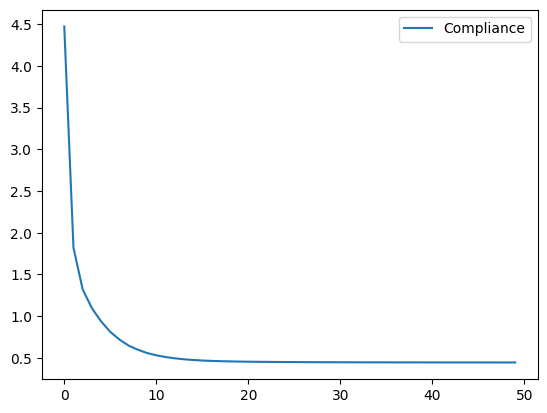

In [2]:
# NOTE: All values in standard units: m, N, Pa
length = 0.2
height = 0.1
width = 0.01
force = -100.0
E_0 = 70e9  # Young's modulus of solid
E_min = 1e-9 * E_0  # Young's modulus of void
nu = 0.35  # Poisson's ratio
penalty = 3
filter_radius = 0.001
move = 0.2
volume_fraction = 0.3
num_steps = 50

use_quad_mesh = False
use_bracket = False
use_bracket_2 = True

# Mesh
if use_quad_mesh:
    ny = 50
    nx = int(length / height * ny)
    mesh = Mesh(quad_mesh(size_x=length, size_y=height, nx=nx, ny=ny))
elif use_bracket:
    mesh = Mesh(bracket(maxh=0.002))
elif use_bracket_2:
    mesh = Mesh(bracket_2(maxh=0.001))
else:
    beam = Rectangle(length, height).Face()
    beam.faces.name = "active"
    beam.edges.Min(X).name = "fix"
    beam.edges.Max(X).name = "force"
    geo = OCCGeometry(beam, dim=2)
    mesh = Mesh(geo.GenerateMesh(maxh=height / 70.0))

# Design space (element-wise constant)
fes_rho = L2(mesh, order=0)
rho = GridFunction(fes_rho)
rho_filtered = GridFunction(fes_rho)

domain_densities = [volume_fraction if mat == "active" else 1.0 for mat in mesh.GetMaterials()]
rho.Set(CoefficientFunction(domain_densities))

E = E_min + rho_filtered**penalty * (E_0 - E_min)
lam, mu = lame_parameters(E, nu)

# Displacement space
fes_u = VectorH1(mesh, order=2, dirichlet="fix")
u = fes_u.TrialFunction()
v = fes_u.TestFunction()
u_gf = GridFunction(fes_u)

# Linear elasticity system
a = BilinearForm(
    InnerProduct(stress(strain(u), mu, lam), strain(v)).Compile() * dx,
    symmetric=True,
    symmetric_storage=True,
)
a.Assemble()
inv = a.mat.Inverse(freedofs=fes_u.FreeDofs(), inverse="sparsecholesky")
f = LinearForm(CoefficientFunction((0, force / (width * height))) * v * ds("force"))
# f = LinearForm(fes_u)
# f += (-force * v[1])(length, height * 0.5)
f.Assemble()

filter = HelmholtzFilter(mesh, filter_radius)

# NOTE: this is ∇_ρ V, where ρ is the "physical" density used in the SIMP interpolation
# formula (so the filtered and projected density).
# This corresponds to x^hat in the top99neo paper.
volume_sensitivity = GridFunction(fes_rho)
volume_sensitivity.vec.FV().NumPy()[:] = Integrate(1, mesh, element_wise=True).NumPy()
filter.apply(volume_sensitivity, volume_sensitivity)

# c = u^T*K*u
# ∇_ρ(c) = -u^T*∇_ρ(K)*u,    where K=E*K0
# ∇_ρ(c) = -penal*ρ**(penal-1)*(E0-Emin)) * u^T*K0*u
compliance_sensitivity = GridFunction(fes_rho)
lam_0, mu_0 = lame_parameters(1.0, nu)  # FIXME: is this correct? Should this be E_0?
energy_integrand = InnerProduct(stress(strain(u_gf), mu_0, lam_0), strain(u_gf)).Compile()

scene = Draw(
    rho_filtered,
    mesh,
    autoscale=False,
    min=0,
    max=1,
    settings={
        "Colormap": {"ncolors": 32},
        "Objects": {"Wireframe": False},
        "Light": {"shininess": 0.0, "specularity": 0.0},
        # "camera": {
        #    "transformations": [
        #        {"type": "move", "dir": (0, 0, 1), "dist": 1.2},
        #    ]
        # },
    },
)

compliance = []

with TaskManager():
    for step in tqdm(range(num_steps)):
        filter.apply(rho, rho_filtered)

        a.Assemble()
        inv.Update()
        u_gf.vec.data = inv * f.vec

        element_energies = Integrate(energy_integrand, mesh, element_wise=True)
        compliance_sensitivity.vec.FV().NumPy()[:] = (
            -penalty
            * (E_0 - E_min)
            * rho_filtered.vec.FV().NumPy() ** (penalty - 1)
            * element_energies.NumPy()
        )
        filter.apply(compliance_sensitivity, compliance_sensitivity)

        optimality_criterion(
            rho, compliance_sensitivity, volume_sensitivity, move, volume_fraction, mesh
        )

        compliance.append(InnerProduct(u_gf.vec, f.vec))

        scene.Redraw()

fig, ax = plt.subplots()
ax.plot(compliance, label="Compliance")
ax.legend()
plt.show()